<a id='main' name="main"></a>
# Vital Data Analysis

Date: 2022.10.08  
Author: © 2022 [Brigita Vileikytė](https://www.linkedin.com/in/brigita-vileikyte/)</br>
Lecturer: © 2022 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

In this work we answer the questions:
1. [Is there any correlation between new deaths per million in a country on 2020 each month with the reproduction rate difference from 2020 to 2021?](#Q1)
2. [How does stringency and new vaccinations in the country during pandemic affected new registered Covid cases per million in 2021?](#Q2)
3. [How well can we classify European continent response for education format based on country's total new Covid case (per million), new and total vaccinations (per million), stringency index and ICU patients (per million) from 2020 to 2021?](#Q3)

Using the open data from: 
* [Our World in Data](https://ourworldindata.org/) COVID-19 data from <https://covid.ourworldindata.org/data/owid-covid-data.csv>
* [COVID-19 impact on education](https://data.world/liz-friedman/covid-19-impact-on-education) data from <https://data.world/> with registered account

This notebook is partially based on:
* Work by M. Lukoševičius lab examples
* Multiple regression model testing variation is created based [on this publication](https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/). Code has been modified from classification models to regression ones.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

In [1]:
import numpy as np
from numpy import NaN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import datetime


Importing sklearn helpers that are used among different computations in the solution

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import model_selection
from sklearn.model_selection import train_test_split


## Load the data

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [3]:
# import requests
# fname = 'owid-covid-data.csv'
# url = 'https://covid.ourworldindata.org/data/' + fname
# r = requests.get(url)
# open(fname, 'wb').write(r.content)


63393155

Load the file to Pandas.

In [4]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv"
world_covid_df = pd.read_csv(url, parse_dates=[3])


#### Getting base info about imported covid data set

 - View of a data set
 - Column details
 - Shape
 - Etc.

 The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

For quick data insights use:
 - ``data_set.head()``
 - ``data_set.info()``
 - ``data_set.describe()``
 - ``data_set.shape``

In [5]:
print("Data set shape:")
print(world_covid_df.shape)

print("Data sample:")
world_covid_df.head(5)


Data set shape:
(224018, 67)
Data sample:


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


Quick world Covid data set review.

In [6]:
world_covid_df.describe()


,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,2.148420e+05,2.145690e+05,2.133730e+05,1.956780e+05,195605.000000,194425.000000,213860.000000,213587.000000,212396.000000,194709.000000,...,139000.000000,137097.000000,90389.000000,163419.000000,209334.000000,179110.00000,8.657000e+03,8657.000000,7750.000000,8657.000000
mean,4.372467e+06,1.241052e+04,1.244658e+04,7.353604e+04,139.410874,140.111789,59143.724299,189.657619,190.034430,685.613030,...,10.675398,32.809437,50.930707,3.089098,73.619310,0.72481,4.431805e+04,8.718123,14.001955,1088.545528
std,2.735676e+07,8.555378e+04,8.361741e+04,3.784089e+05,733.158343,718.730143,105141.548457,1053.474182,668.825112,971.519796,...,10.625905,13.534613,31.882545,2.552402,7.446108,0.14961,1.348950e+05,17.017667,26.912459,3159.348548
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.39400,-2.793838e+05,-77.540000,-95.920000,-29168.813911
25%,4.234000e+03,0.000000e+00,6.143000e+00,1.120000e+02,0.000000,0.000000,1063.982500,0.000000,1.355750,29.176000,...,1.900000,21.600000,20.859000,1.300000,69.500000,0.60200,3.450000e+01,0.630000,-0.177500,33.540258
50%,4.810900e+04,5.500000e+01,9.528600e+01,1.158000e+03,1.000000,1.571000,10082.325000,7.707000,19.492500,209.939000,...,6.300000,31.400000,49.839000,2.500000,75.050000,0.74200,5.475800e+03,7.500000,7.235000,814.196157
75%,5.156450e+05,9.660000e+02,1.133143e+03,9.709000e+03,14.000000,15.857000,71288.586500,97.900500,136.075500,1015.987000,...,19.300000,41.300000,83.241000,4.200000,79.070000,0.84500,3.369160e+04,15.720000,19.735000,2139.058790
max,6.244073e+08,4.081747e+06,3.436276e+06,6.566861e+06,17737.000000,14858.286000,662430.093000,195005.313000,36401.607000,6431.914000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.95700,1.224011e+06,76.550000,376.510000,9766.306877


In [7]:
print("Base details about registered countries:")
world_covid_df['iso_code'].describe()

# Uncomment if details about each registered country is needed
# print("Country usage")
# covid_data_set['iso_code'].value_counts().head(15)


Base details about registered countries:


count     224018
unique       244
top          ARG
freq        1019
Name: iso_code, dtype: object

### Declaring reusable functions and constants in the notebook

Defining reusable constants in the project for unified diagrams and colors:

In [8]:
default_figsize = (8, 6)
square_figsize = (6, 6)
extended_figsize = (14, 6)
cmap_color = 'Blues'
dark_blue = "#123459"
blue = "#2a69d5"


Defining reusable functions:

In [9]:
def filter_by_time_range(data_frame: pd.DataFrame, date_from, date_to) -> pd.DataFrame:
    data_frame = data_frame[((data_frame['date'] >= date_from) &
                             (data_frame['date'] <= date_to))]
    return data_frame


Creating a reusable function for defining simple characteristics of regression models.</br></br>
__RSME__ - _the standard deviation of the prediction errors. It tells you how concentrated the data is around the line of best fit.</br>_
__R2_Score__ - _coefficient of determination: 1 is perfect prediction. It is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. A constant model that always predicts the average y disregarding the input features would get a r*r score of 0.0._

In [10]:
def define_predictions(regresion_model, expected_result, actual_result, print_coef=False, print_results=False) -> dict:
    """Printing out the model coefficiets.\n Calculating RSME and R2 score based on expected and predicted values."""
    if print_coef:
        if len(regresion_model.coef_) < 10:
            print("Coefficients:\n", regresion_model.coef_)
        else:
            print("Coefficient array is too long to be displayed.")

    rsme = mean_squared_error(expected_result, actual_result, squared=False)
    r2 = r2_score(expected_result, actual_result)

    if print_results:
        print("Mean squared error: %.2f" % rsme)
        print("Coefficient of determination: %.2f\n" % r2)

    return {'RSME': rsme, 'R2_score': r2}


In [11]:
def plot_model_results_metrics(results: pd.DataFrame, group_col: str, compare_col: str, compare_label: str,
                               compare_col2: str, compare_label2: str, title: str, x_label: str):
    plt.subplots(figsize=extended_figsize)
    X_axis = np.arange(len(results[group_col]))

    plt.bar(X_axis - 0.2, results[compare_col], 0.4,
            color=dark_blue, label=compare_label)
    plt.bar(X_axis + 0.2, results[compare_col2],
            0.4, color=blue, label=compare_label2)
            
    plt.title(title)
    plt.xlabel(x_label)
    plt.xticks(X_axis, results[group_col])

    plt.legend()

[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Is there any __correlation__ between __new deaths per million__ in a country on 2020 each month with the __reproduction rate difference__ from 2020 to 2021?

### Preparing the data

Specifying the selected time ranges for analysis

In [12]:
date_from_2020 = datetime(2020, 1, 1).strftime('%Y-%m-%d')
date_to_2020 = datetime(2020, 12, 31).strftime('%Y-%m-%d')

date_from_2021 = datetime(2021, 1, 1).strftime('%Y-%m-%d')
date_to_2021 = datetime(2021, 12, 31).strftime('%Y-%m-%d')

print("Covid test cases time range from %s to %s" %
      (date_from_2020, date_to_2020))
print("Reproduction rate in a country from %s to %s" %
      (date_from_2021, date_to_2021))


Covid test cases time range from 2020-01-01 to 2020-12-31
Reproduction rate in a country from 2021-01-01 to 2021-12-31


Splitting the data and taking only columns we are interested in

In [13]:
world_covid_df['date'] = pd.to_datetime(world_covid_df['date'])
minimzed_covid_df = world_covid_df[[
    'iso_code', 'continent', 'date', 'total_cases_per_million', 'new_cases_per_million', 'new_deaths_per_million', 'reproduction_rate']]


Converting categroical continent values to processable integer values that can be used for predictions later on.

In [14]:
minimzed_covid_df['continent'] = minimzed_covid_df[[
    'continent']].apply(lambda continent: pd.Categorical(continent).codes)

minimzed_covid_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224018 entries, 0 to 224017
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   iso_code                 224018 non-null  object        
 1   continent                224018 non-null  int8          
 2   date                     224018 non-null  datetime64[ns]
 3   total_cases_per_million  213860 non-null  float64       
 4   new_cases_per_million    213587 non-null  float64       
 5   new_deaths_per_million   194636 non-null  float64       
 6   reproduction_rate        166717 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int8(1), object(1)
memory usage: 10.5+ MB


C:\Users\Dell\AppData\Local\Temp\ipykernel_1568\198960937.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minimzed_covid_df['continent'] = minimzed_covid_df[[


Seleting the time ranges of minimized data set.</br>
Data sample is split into 2 sets for __2020__ and __2021__</br>

In [15]:
minimized_covid_df_20 = filter_by_time_range(
    minimzed_covid_df, date_from_2020, date_to_2020)
minimized_covid_df_21 = filter_by_time_range(
    minimzed_covid_df, date_from_2021, date_to_2021)


In [16]:
minimized_covid_df_20 = minimized_covid_df_20.assign(
    month_year=minimized_covid_df_20['date'].dt.to_period('M'))
minimized_covid_df_21 = minimized_covid_df_21.assign(
    month_year=minimized_covid_df_21['date'].dt.to_period('M'))


Grouping data based on country and month. Aggregating other columns accordingly for 2020 data set:
 - **continent** - taking the first value
 - **total_cases_per_million** - taking the last value
 - **new_cases_per_million** - sum of all values over the month
 - **new_deaths_per_million** - sum of all the values over the month
 - **reproduction_rate** - taking the last record for the specified month

Data set for 2021 will only require the same grouping by date and time. But we will not need additional columns besides reproduction rate. Therefore, for the 2021 data set we are dropping unnecessary values.

In [17]:
minimized_covid_df_20 = minimized_covid_df_20.groupby(['iso_code', 'month_year']).agg({
    'date': 'first',
    'continent': 'first',
    'total_cases_per_million': 'last',
    'new_cases_per_million': 'sum',
    'new_deaths_per_million': 'sum',
    'reproduction_rate': 'mean'
}).reset_index()


In [18]:
minimized_covid_df_21 = minimized_covid_df_21.groupby(['iso_code', 'month_year']).agg({
    'date': 'first',
    'continent': 'first',
    'total_cases_per_million': 'last',
    'new_cases_per_million': 'sum',
    'new_deaths_per_million': 'sum',
    'reproduction_rate': 'mean'
}).reset_index()

minimized_covid_df_21.drop(columns=['continent', 'total_cases_per_million',
                           'total_cases_per_million', 'new_cases_per_million', 'new_deaths_per_million'], inplace=True)


Calculating the new column for 2020 data set. We are getting the difference in value for reproduction rate based on the same months compared to 2021.

In [19]:
def get_equivalent_month_repr_rate(row_to_match, covid_df):
    matching_row = covid_df[((covid_df['iso_code'] == row_to_match['iso_code']) & (covid_df['date'].dt.month == row_to_match['date'].month) & (
        covid_df['date'].dt.day == row_to_match['date'].day))][:1]['reproduction_rate']

    found_reproduction_rate = matching_row.iloc[0] if len(
        matching_row) != 0 else NaN

    returnValue = row_to_match['reproduction_rate'] - found_reproduction_rate

    return returnValue


In [20]:
reproduction_rate_diff_col = minimized_covid_df_20.apply(
    lambda row: get_equivalent_month_repr_rate(row, minimized_covid_df_21), axis=1)

minimized_covid_df_20 = minimized_covid_df_20.assign(
    reproduction_rate_diff=reproduction_rate_diff_col.values)


Droping non predictable outcomes and no longer relavent colums:

In [21]:
minimized_covid_df_20 = minimized_covid_df_20.dropna(
    subset=['reproduction_rate_diff'])

minimized_covid_df_20.drop(['month_year'], axis=1, inplace=True)


In [22]:
minimized_covid_df_20.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 11 to 2354
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   iso_code                 1606 non-null   object        
 1   date                     1606 non-null   datetime64[ns]
 2   continent                1606 non-null   int8          
 3   total_cases_per_million  1606 non-null   float64       
 4   new_cases_per_million    1606 non-null   float64       
 5   new_deaths_per_million   1606 non-null   float64       
 6   reproduction_rate        1606 non-null   float64       
 7   reproduction_rate_diff   1606 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int8(1), object(1)
memory usage: 101.9+ KB


### Quick correlation visualisation

Having a visual representation of correlation between the variables we are interested in:

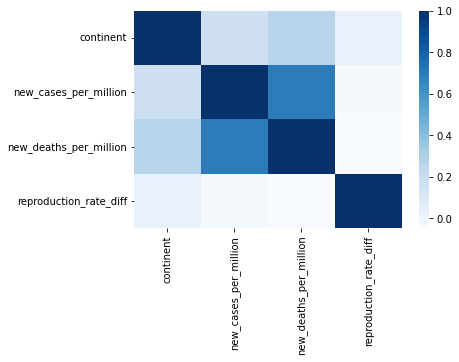

In [23]:
plt.figure()
sns.heatmap(minimized_covid_df_20[['continent', 'new_cases_per_million',
            'new_deaths_per_million', 'reproduction_rate_diff']].corr(), cmap=cmap_color)
plt.show()


Visualise the distribution of reproduction rate difference in 2021 based on new deaths per million in 2020.</br>
Compute best linear fit.</br>

_Visualisation is based on M. Lukoševičius notebook example._

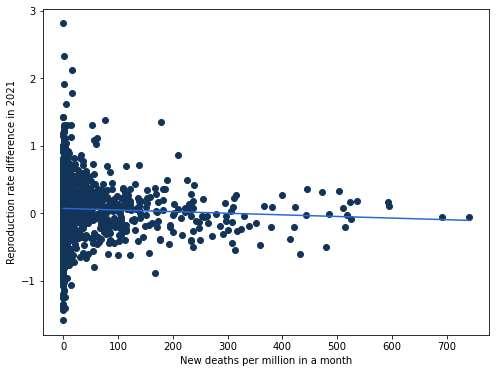

In [24]:
plt.figure(figsize=default_figsize)

plt.xlabel('New deaths per million in a month')
plt.ylabel('Reproduction rate difference in 2021')

plt.scatter(minimized_covid_df_20.new_deaths_per_million,
            minimized_covid_df_20.reproduction_rate_diff, color=dark_blue)

coef = np.ma.polyfit(np.ma.masked_invalid(minimized_covid_df_20.new_deaths_per_million),
                     np.ma.masked_invalid(minimized_covid_df_20.reproduction_rate_diff), deg=1)
new_deaths_interval = np.linspace(minimized_covid_df_20.new_deaths_per_million.min(),
                                  minimized_covid_df_20.new_deaths_per_million.max(), 100)


plt.plot(new_deaths_interval, coef[1] + coef[0]
         * new_deaths_interval, '-', color=blue)


In [25]:
np.ma.corrcoef(np.ma.log(np.ma.masked_invalid(minimized_covid_df_20.new_deaths_per_million)),
               np.ma.log(np.ma.masked_invalid(minimized_covid_df_20.reproduction_rate_diff)))[0, 1]


-0.15821102614316637

From the diagram and linear prediction visualisation we can see that there is little to none correlation between selected fields.

### Verifying the correlation between selected data

After initial visualisation of data correlation it is visile that selected data doesn't correlate a lot. Moreover, data has a lot of outlier values.</br>
We will remove the outlier values in the selected data based on __zscore__ for _new_deaths_per_million_ column. 

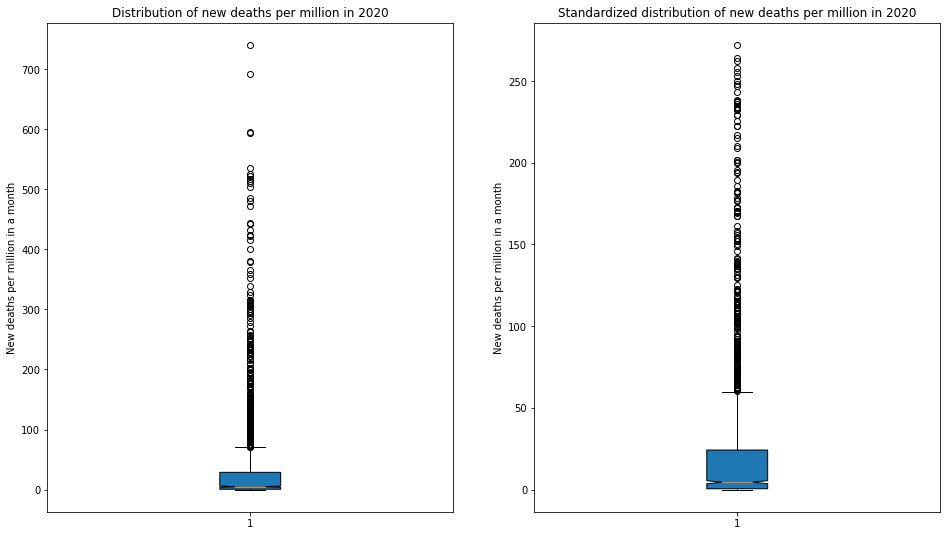

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(
    default_figsize[0]*2, default_figsize[1]*1.5))

ax1.set_title('Distribution of new deaths per million in 2020')
ax1.set_ylabel('New deaths per million in a month')
ax1.boxplot(minimized_covid_df_20.new_deaths_per_million,
            notch=True, patch_artist=True)

# filter out rows that have a big outline values on new_deaths_per_million column
minimized_covid_df_20 = minimized_covid_df_20[(
    np.abs(stats.zscore(minimized_covid_df_20['new_deaths_per_million'])) < 3)]

ax2.set_title('Standardized distribution of new deaths per million in 2020')
ax2.set_ylabel('New deaths per million in a month')
ax2.boxplot(
    minimized_covid_df_20['new_deaths_per_million'], notch=True, patch_artist=True)

plt.show()


Defining a helper function for plotting the predictions based on trained linear model results when the input is a single feature.

In [27]:
def plot_prediction_values(x_train, y_train, x_test, y_test, y_predicted, x_label: str, y_label: str, title: str):
    plt.figure(figsize=default_figsize)

    plt.scatter(x_train, y_train, color=dark_blue, label='Training points')
    plt.scatter(x_test, y_test, color='b', label='Testing points')

    # Forming new DF to sort the linear prediction values in order to have a better visualisation
    predicted_df = pd.DataFrame(
        {'x_test': x_test.reshape(-1), 'y_predicted': y_predicted}).sort_values(by=['x_test'])
    plt.plot(predicted_df.x_test, predicted_df.y_predicted,
             color=blue, linewidth=2, label='Predictions')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


Defining a polynomial regression function that trains the linear regression model based on the given degree.

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


def polynomial_regression(poly_degree: int, x_train: np.array, y_train: np.array, x_test: np.array, y_test: np.array, plot_predictions=True) -> dict:
    poly_ft = PolynomialFeatures(degree=poly_degree, include_bias=True)
    linear_training_model = LinearRegression()

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    x_train_transformed = poly_ft.fit_transform(x_train)
    x_test_transformed = poly_ft.fit_transform(x_test)

    prediction_model = linear_training_model.fit(x_train_transformed, y_train)
    predicted_values = prediction_model.predict(x_test_transformed)

    model_score = prediction_model.score(x_test_transformed, y_test)

    if plot_predictions:
        plot_prediction_values(x_train, y_train, x_test, y_test, predicted_values,
                               'New deaths per month', 'Reproduction rate difference', f'Predictions with poly degree = {poly_degree}')

    prediction_result = define_predictions(
        prediction_model, y_test, predicted_values)
    prediction_result['poly_degree'] = poly_degree
    prediction_result['pred_score'] = model_score

    return prediction_result


Selecting the data we want to analyse and split it into testing and validation data sets.</br>
After selecting the data we will reshape the training data sets into an expected numpy array format for linear regression models.

In [29]:
x_traing_new_deaths, x_test_new_deaths, y_train_repr_diff, y_test_repr_diff = train_test_split(
    minimized_covid_df_20.new_deaths_per_million, minimized_covid_df_20.reproduction_rate_diff, test_size=0.3, random_state=10, shuffle=False)

# Alternative x_training_new_deaths.values
x_traing_new_deaths = np.array(x_traing_new_deaths).reshape(
    len(x_traing_new_deaths), 1)
x_test_new_deaths = np.array(x_test_new_deaths).reshape(
    len(x_test_new_deaths), 1)


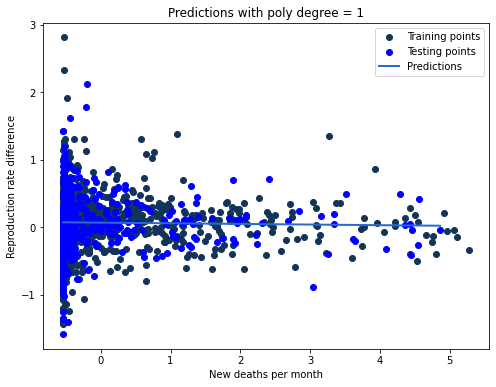

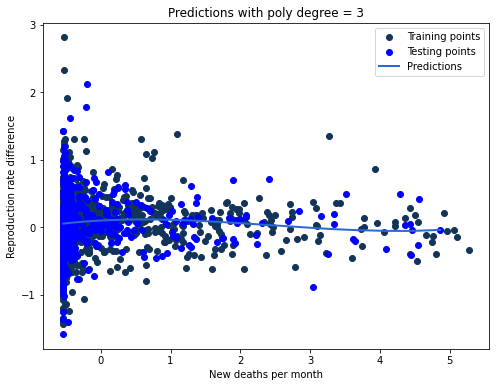

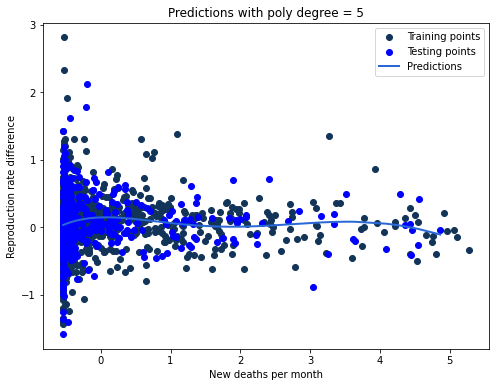

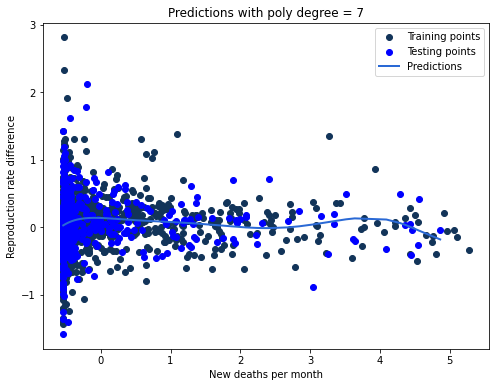

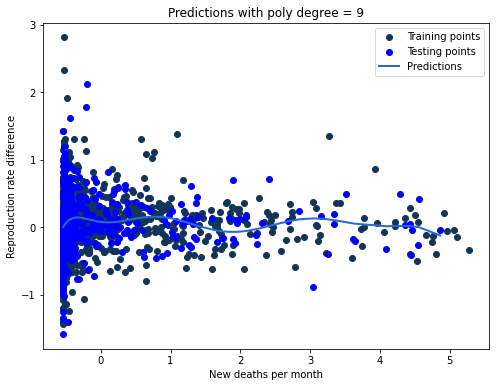

In [30]:
polynomial_model_results = []

for poly_degree in range(1, 10, 2):
    regression_model_result = polynomial_regression(poly_degree, x_traing_new_deaths,
                                                    y_train_repr_diff, x_test_new_deaths, y_test_repr_diff)

    polynomial_model_results.append(regression_model_result)


Creating the results table for the trained linear regression model:

In [31]:
trained_results = pd.DataFrame(polynomial_model_results)
trained_results = trained_results.reindex(
    columns=['poly_degree', 'pred_score', 'RSME', 'R2_score'])
trained_results


,poly_degree,pred_score,RSME,R2_score
0,1,0.000065,0.433636,0.000065
1,3,0.007191,0.432089,0.007191
2,5,0.018791,0.429557,0.018791
3,7,0.021713,0.428917,0.021713
4,9,0.023859,0.428446,0.023859


### Trying to predict reproduction rate difference with linear regressiong model with more input values for covid data set

In [32]:
x_traing_new_cases, x_test_new_cases, y_train_repr_diff, y_test_repr_diff = train_test_split(
    minimized_covid_df_20[['continent', 'total_cases_per_million', 'new_cases_per_million', 'new_deaths_per_million']], minimized_covid_df_20['reproduction_rate_diff'], test_size=0.3, random_state=40, shuffle=False)

x_traing_new_cases = np.array(x_traing_new_cases).reshape(
    len(x_traing_new_cases), len(x_traing_new_cases.columns))
x_test_new_cases = np.array(x_test_new_cases).reshape(
    len(x_test_new_cases), len(x_test_new_cases.columns))


In [33]:
polynomial_multi_input_model_results = []

for poly_degree in range(1, 6, 2):
    regression_model_result = polynomial_regression(poly_degree, x_traing_new_cases,
                                                    y_train_repr_diff, x_test_new_cases, y_test_repr_diff, False)

    polynomial_multi_input_model_results.append(regression_model_result)


Creating the results table for the trained linear regression model with multi-inputs:

In [34]:
trained_multi_input_results = pd.DataFrame(
    polynomial_multi_input_model_results)
trained_multi_input_results = trained_multi_input_results.reindex(
    columns=['poly_degree', 'pred_score', 'RSME', 'R2_score'])
trained_multi_input_results


,poly_degree,pred_score,RSME,R2_score
0,1,0.032478,0.426550,0.032478
1,3,0.027770,0.427587,0.027770
2,5,-15.644141,1.769174,-15.644141


From the simplified prediction table, we can see that prediction results hadn't increased in a significant value even if we took more variables for the training of the model.</br>
These very low linear regression prediction scores for the reproduction rate difference based on the Covid pandemic variables has to verify that reproduction rate wasn't solely impacted by the pandemic in the first year.</br>
This can be expected and for sure varies among each country individually. But people most likely have others impacting economical and social features that impact of their decisions on creating/expanding the families.

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. How does stringency and vaccinations in the country during pandemic affected new registered Covid cases per million in 2021?

### Preparing the data

Selecting the data we will be interested in.</br>
Filtering only relevant time ranges for the specified dataset.</br>

In [35]:
vacinations_covid_df = world_covid_df[[
    'iso_code', 'date', 'new_vaccinations_smoothed_per_million', 'people_vaccinated_per_hundred', 'stringency_index', 'new_cases_per_million']]
vacinations_covid_df_21 = vacinations_covid_df[((vacinations_covid_df['date'] >= date_from_2021) &
                                                (vacinations_covid_df['date'] <= date_to_2021))]


Cleaning and preparing the data

In [36]:
relev_data = vacinations_covid_df_21[[
    'new_vaccinations_smoothed_per_million', 'people_vaccinated_per_hundred', 'stringency_index', 'new_cases_per_million']]

relev_data = relev_data.dropna()

relev_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29014 entries, 370 to 223729
Data columns (total 4 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   new_vaccinations_smoothed_per_million  29014 non-null  float64
 1   people_vaccinated_per_hundred          29014 non-null  float64
 2   stringency_index                       29014 non-null  float64
 3   new_cases_per_million                  29014 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


### Quick correlation visualisation

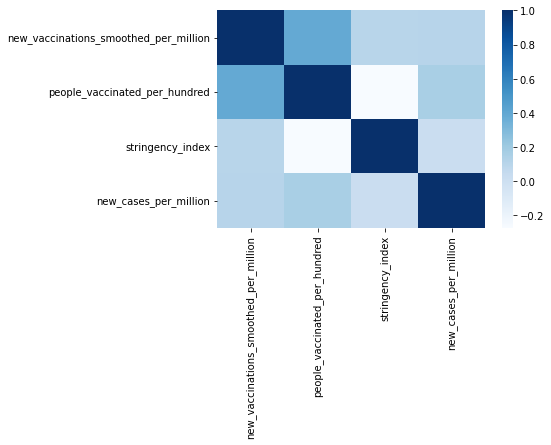

In [37]:
plt.figure()
sns.heatmap(relev_data.corr(), cmap=cmap_color)
plt.show()


### Creating and training the regression models

In [38]:
X_train, X_test, y_train, y_test = train_test_split(relev_data[['new_vaccinations_smoothed_per_million',
                                                                'people_vaccinated_per_hundred', 'stringency_index']],
                                                    relev_data[[
                                                        'new_cases_per_million']],
                                                    test_size=0.3, random_state=15, shuffle=True)


Selecting the models for regression predictions.</br>
Models for multiclass classification had been selected based on [website](https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/)

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

models = [
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet()),
    ('BayesianRidge', BayesianRidge()),
    ('DecisionTreeRegression', DecisionTreeRegressor()),
    ('KNeighborsRegressor', KNeighborsRegressor())
]


Creating helper function for selecting the evaluation metrics for the trained regression model.</br></br>

_For the most common use cases we can simply evaluate our model based on the simple scorer object with the scoring parameter. But if we want more details about how our regression model performs we can have additional metricts.</br>
All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric._

In [40]:
def get_regression_model_metrics(name, cv_results: dict,
                                 y_train: np.array, y_train_pred: np.array, y_test: np.array, y_test_pred: np.array) -> dict:
    round_precision = 3

    mae_scores = cv_results['test_neg_root_mean_squared_error']
    r2_scores = cv_results['test_r2']

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    return {
        'model': name,
        'kfold_rmea_score': round(mae_scores.mean(), round_precision),
        'kfold_rmea_std': round(mae_scores.std(), round_precision),
        'kfold_r2_score': round(r2_scores.mean(), round_precision),
        'kfold_r2_std': round(r2_scores.std(), round_precision),
        'train_rmse': round(train_rmse, round_precision),
        'train_r2_score': round(train_r2, round_precision),
        'test_rmse': round(test_rmse, round_precision),
        'test_r2_score': round(test_r2, round_precision)
    }


_Training multiple models script is based [on the publication about](https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0) trying to select the best classification model. The script is modified to fit personal needs and support regression models._

In [41]:
def analyze_regression_models(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame,
                              models: list, scale_data=True) -> pd.DataFrame:
    '''
    Quickly train and evaluate given regression models that implement fix fuction with the K_Fold validation
    :return: DataFrame of prediction results with RMEA, R2 scores
    '''
    results = []
    scoring_metrics = ['max_error', 'neg_mean_squared_error',
                       'neg_root_mean_squared_error', 'r2']

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    for model_name, regression_model in models:
        if scale_data:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        kfold = model_selection.KFold(
            n_splits=5, shuffle=True, random_state=30)
        cv_results = model_selection.cross_validate(
            regression_model, X_train, y_train, cv=kfold, scoring=scoring_metrics)

        fully_trained_model = regression_model.fit(X_train, y_train)

        train_set_pred = fully_trained_model.predict(X_train)
        test_set_pred = fully_trained_model.predict(X_test)

        model_res_dict = get_regression_model_metrics(
            model_name, cv_results, y_train, train_set_pred, y_test, test_set_pred)
        results.append(model_res_dict)

    return pd.DataFrame(results)


In [42]:
regression_model_results = analyze_regression_models(
    X_train, y_train, X_test, y_test, models, False)

regression_model_results


,model,kfold_rmea_score,kfold_rmea_std,kfold_r2_score,kfold_r2_std,train_rmse,train_r2_score,test_rmse,test_r2_score
0,LinearRegression,-310.997,15.275,0.032,0.006,311.278,0.032,317.380,0.033
1,Ridge,-310.997,15.275,0.032,0.006,311.278,0.032,317.380,0.033
2,ElasticNet,-310.997,15.275,0.032,0.006,311.278,0.032,317.380,0.033
3,BayesianRidge,-310.998,15.277,0.032,0.006,311.279,0.032,317.382,0.033
4,DecisionTreeRegression,-304.176,23.235,0.071,0.114,3.235,1.000,306.655,0.097
5,KNeighborsRegressor,-327.875,13.338,-0.077,0.021,266.555,0.290,324.884,-0.013


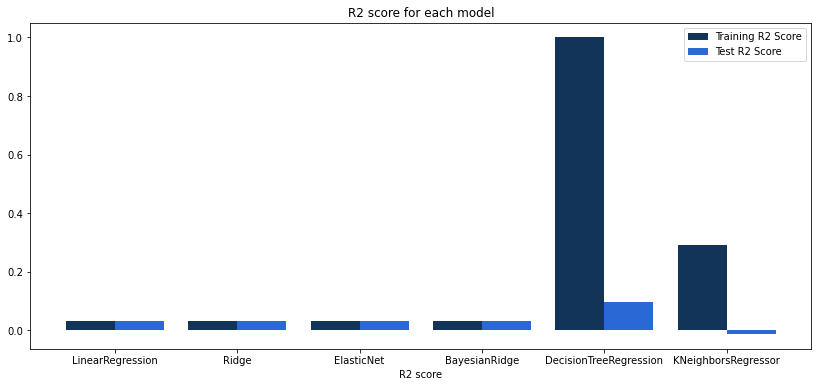

In [43]:
plot_model_results_metrics(regression_model_results, 'model', 'train_r2_score', 'Training R2 Score',
                           'test_r2_score', 'Test R2 Score',
                           'R2 score for each model', 'R2 score')


So the models haven't performed very well when predicting new cases based on the feature inputs that had been selected. One thing to notice here is that the decision tree regression classifier actually had a very high R2 score on the training data set. It most likely memorized the data and didn't actually learned of it.

In [44]:
scaled_input_regression_model_results = analyze_regression_models(
    X_train, y_train, X_test, y_test, models)

scaled_input_regression_model_results


,model,kfold_rmea_score,kfold_rmea_std,kfold_r2_score,kfold_r2_std,train_rmse,train_r2_score,test_rmse,test_r2_score
0,LinearRegression,-310.997,15.275,0.032,0.006,311.278,0.032,317.380,0.033
1,Ridge,-310.997,15.275,0.032,0.006,311.278,0.032,317.380,0.033
2,ElasticNet,-311.580,15.237,0.028,0.004,311.893,0.028,318.119,0.029
3,BayesianRidge,-310.997,15.276,0.032,0.006,311.278,0.032,317.382,0.033
4,DecisionTreeRegression,-299.658,19.913,0.098,0.099,3.235,1.000,304.585,0.110
5,KNeighborsRegressor,-258.751,14.557,0.329,0.037,201.588,0.594,255.192,0.375


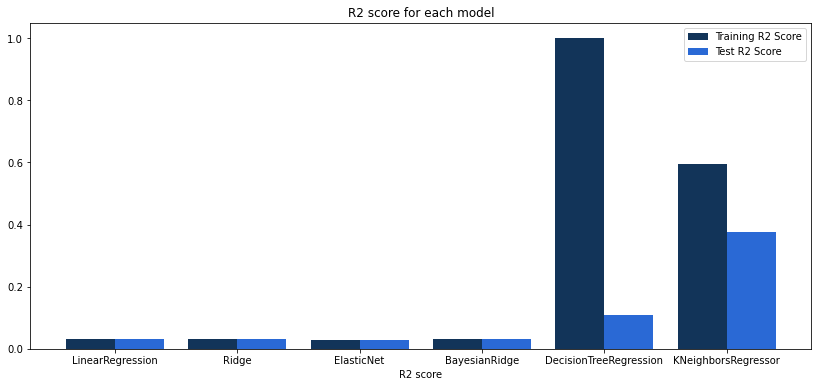

In [45]:
plot_model_results_metrics(scaled_input_regression_model_results, 'model', 'train_r2_score', 'Training R2 Score',
                           'test_r2_score', 'Test R2 Score',
                           'R2 score for each model', 'R2 score')


[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. How well can we classify European continent response for education format based on country's total new Covid case (per million), new and total vaccinations (per million), stringency index and ICU patients (per million) from 2020 to 2021? 

### Preparing the data

Loading the dataset for education response to Covid cases from 2020 to 2021

In [46]:
url = "covid_impact_education.csv"
education_impact_df = pd.read_csv(url, parse_dates=[3])


In [47]:
education_impact_df.columns = education_impact_df.columns.str.lower()

education_impact_df.rename(
    columns={"iso": "iso_code", "status": "school_status"}, inplace=True)
education_impact_df['date'] = pd.to_datetime(
    education_impact_df['date'], format='%d/%m/%Y', errors='coerce')

education_impact_df


,date,iso_code,country,school_status,note
0,2020-02-17,ABW,Aruba,Fully open,NaN
1,2020-02-17,AFG,Afghanistan,Fully open,NaN
2,2020-02-17,AGO,Angola,Fully open,NaN
3,2020-02-17,AIA,Anguilla,Fully open,NaN
4,2020-02-17,ALB,Albania,Fully open,NaN
...,...,...,...,...,...
25615,2022-02-28,WSM,Samoa,Fully open,NaN
25616,2022-02-28,YEM,Yemen,Fully open,NaN
25617,2022-02-28,ZAF,South Africa,Fully open,NaN
25618,2022-02-28,ZMB,Zambia,Fully open,NaN


Filtering only European continent related data

In [48]:
eu_covid_df = world_covid_df[world_covid_df['continent'] == 'Europe'][['date', 'iso_code', 'location', 'new_cases_per_million',
                                                                       'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred', 'stringency_index', 'icu_patients_per_million']]


Combining datasets based on country and the record date

In [49]:
combined_covid_data = pd.merge(eu_covid_df, education_impact_df,
                               on=['iso_code', 'date'], how='inner')
print(combined_covid_data.shape)
combined_covid_data.head()


(5576, 11)


,date,iso_code,location,new_cases_per_million,people_fully_vaccinated_per_hundred,new_people_vaccinated_smoothed_per_hundred,stringency_index,icu_patients_per_million,country,school_status,note
0,2020-03-16,ALB,Albania,3.153,NaN,NaN,81.48,NaN,Albania,Closed due to COVID-19,NaN
1,2020-04-20,ALB,Albania,7.707,NaN,NaN,89.81,NaN,Albania,Academic break,NaN
2,2020-05-18,ALB,Albania,0.701,NaN,NaN,83.33,NaN,Albania,Partially open,NaN
3,2020-06-15,ALB,Albania,24.171,NaN,NaN,71.30,NaN,Albania,Partially open,NaN
4,2020-07-20,ALB,Albania,28.374,NaN,NaN,62.96,NaN,Albania,Academic break,NaN


Filtering and cleaning up the data by selected time range from 2020 to the end of 2021.

In [50]:
combined_covid_data = combined_covid_data.drop(
    columns=['location', 'note', 'country'])
combined_covid_data = filter_by_time_range(
    combined_covid_data, date_from_2020, date_to_2021)


In [51]:
combined_covid_data['icu_patients_per_million'] = combined_covid_data['icu_patients_per_million'].fillna(
    0)
combined_covid_data['new_cases_per_million'] = combined_covid_data['new_cases_per_million'].fillna(
    0)
combined_covid_data['people_fully_vaccinated_per_hundred'] = combined_covid_data['people_fully_vaccinated_per_hundred'].fillna(
    0)
combined_covid_data['new_people_vaccinated_smoothed_per_hundred'] = combined_covid_data[
    'new_people_vaccinated_smoothed_per_hundred'].fillna(0)

combined_covid_data = combined_covid_data[combined_covid_data['stringency_index'].notna(
)]

combined_covid_data.shape


(2677, 8)

Creating additional information column for the data record quaters.

In [52]:
combined_covid_data['quarter'] = pd.PeriodIndex(
    combined_covid_data['date'], freq='Q')
combined_covid_data['quarter'] = combined_covid_data['quarter'].astype(
    'category')
combined_covid_data['quarter'] = combined_covid_data['quarter'].cat.codes


Update prediction target values to multicategory value for better classification results.</br>
We can convert categorical values to numeric or one-hot-encoding for trying to get better results.

In [53]:
combined_covid_data["school_status"] = combined_covid_data["school_status"].astype(
    "category")
#combined_covid_data["school_status"] = combined_covid_data["school_status"].cat.codes
combined_covid_data


,date,iso_code,new_cases_per_million,people_fully_vaccinated_per_hundred,new_people_vaccinated_smoothed_per_hundred,stringency_index,icu_patients_per_million,school_status,quarter
0,2020-03-16,ALB,3.153,0.00,0.000,81.48,0.000,Closed due to COVID-19,0
1,2020-04-20,ALB,7.707,0.00,0.000,89.81,0.000,Academic break,1
2,2020-05-18,ALB,0.701,0.00,0.000,83.33,0.000,Partially open,1
3,2020-06-15,ALB,24.171,0.00,0.000,71.30,0.000,Partially open,1
4,2020-07-20,ALB,28.374,0.00,0.000,62.96,0.000,Academic break,2
...,...,...,...,...,...,...,...,...,...
5512,2021-11-29,GBR,626.387,68.92,0.035,43.57,13.615,Fully open,7
5513,2021-12-06,GBR,755.785,69.24,0.037,43.55,13.392,Fully open,7
5514,2021-12-13,GBR,801.905,69.57,0.034,43.54,13.377,Fully open,7
5515,2021-12-20,GBR,1363.445,70.01,0.051,40.74,12.767,Fully open,7


Quick review of combined and prepared data set. Ensuring that no undefined values are left.

In [54]:
combined_covid_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2677 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        2677 non-null   datetime64[ns]
 1   iso_code                                    2677 non-null   object        
 2   new_cases_per_million                       2677 non-null   float64       
 3   people_fully_vaccinated_per_hundred         2677 non-null   float64       
 4   new_people_vaccinated_smoothed_per_hundred  2677 non-null   float64       
 5   stringency_index                            2677 non-null   float64       
 6   icu_patients_per_million                    2677 non-null   float64       
 7   school_status                               2677 non-null   category      
 8   quarter                                     2677 non-null   int8          
dtypes: catego

### Quick correlation visualisation

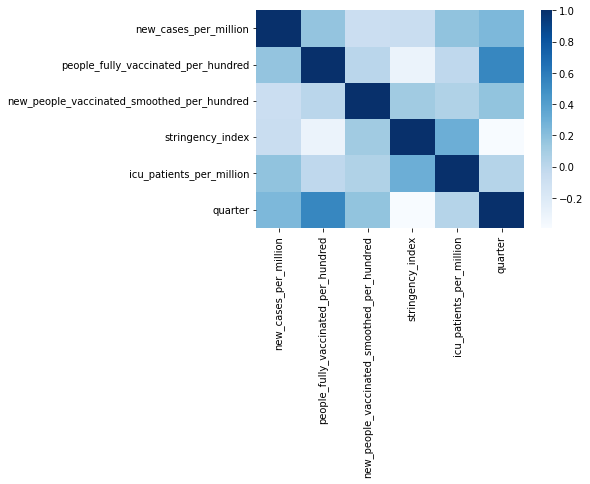

In [55]:
plt.figure()
sns.heatmap(combined_covid_data.corr(), cmap=cmap_color)
plt.show()


### Creating and training the classification models

In [56]:
X_train, X_test, y_train, y_test = train_test_split(combined_covid_data[['new_cases_per_million',
                                                                         'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
                                                                         'stringency_index', 'icu_patients_per_million', 'quarter']],
                                                    combined_covid_data[[
                                                        'school_status']],
                                                    test_size=0.3, random_state=15, shuffle=True)


Selecting the models for classification predictions.</br>
Models for multiclass classification had been selected based on [website](https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/)

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

classification_models = [
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=7)),
    ('GaussianNB', GaussianNB()),
    ('RandomForestClassifier', RandomForestClassifier())
]


Define a helper function for visualising classification results:

In [58]:
def plot_confusion_matrix_res(title: str, matrix_range: tuple, y_test, test_set_pred):
    prediction_conf_matrix = confusion_matrix(y_test, test_set_pred)
    confusion_matrix_df = pd.DataFrame(
        prediction_conf_matrix, range(matrix_range[0]), range(matrix_range[1]))

    plt.figure(figsize=default_figsize)
    sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df),
                cmap=cmap_color, fmt='.2%', annot=True)
    plt.title(title)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()


In [59]:
def get_model_results_row(name, model_score, model_balanced_score, model_f1_score):
    round_precision = 3

    return {
        'model': name,
        'balanced_score': round(model_balanced_score, round_precision),
        'model_f1_score': round(model_f1_score, round_precision),
        'score': round(model_score, round_precision)
    }


In [60]:
def analyze_classification_models(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame,
                                  models: list, scale_data=True) -> pd.DataFrame:
    # Formatting target values for classification into an expected format
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    results = []
    for name, model in models:

        if scale_data:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        fully_trained_model = model.fit(X_train, y_train)
        test_set_pred = fully_trained_model.predict(X_test)

        model_score = fully_trained_model.score(X_test, y_test)
        model_balanced_score = balanced_accuracy_score(
            y_test, test_set_pred)
        model_f1_score = f1_score(y_test, test_set_pred, average='macro')

        plot_confusion_matrix_res(
            f'Confusion matrix for {name} model\nAccuracy {round(model_score, 3)}', (4, 4), y_test, test_set_pred)

        model_results = get_model_results_row(
            name, model_score, model_balanced_score, model_f1_score)
        results.append(model_results)
    return pd.DataFrame(results)


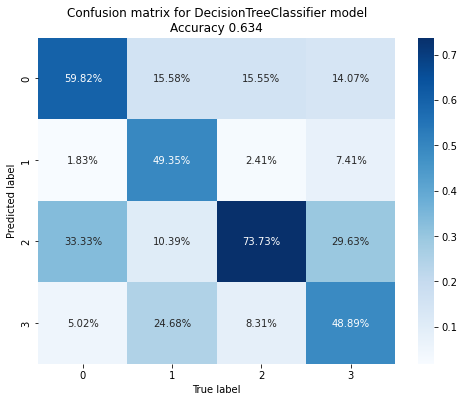

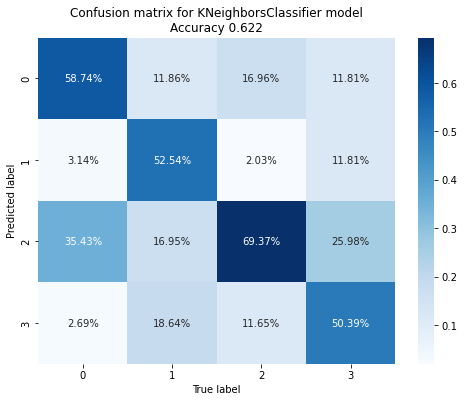

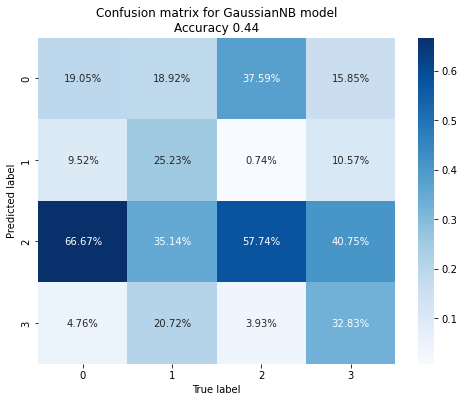

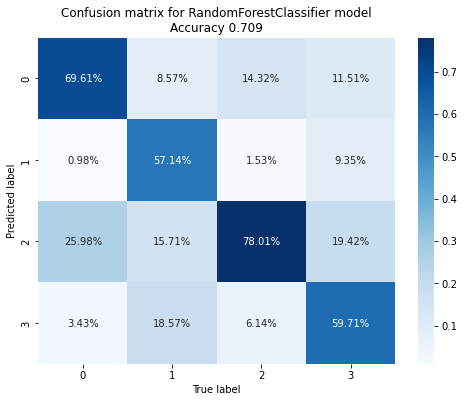

In [61]:
classification_results = analyze_classification_models(
    X_train, y_train, X_test, y_test, classification_models)


In [62]:
classification_results

,model,balanced_score,model_f1_score,score
0,DecisionTreeClassifier,0.608,0.592,0.634
1,KNeighborsClassifier,0.575,0.576,0.622
2,GaussianNB,0.439,0.347,0.440
3,RandomForestClassifier,0.681,0.670,0.709


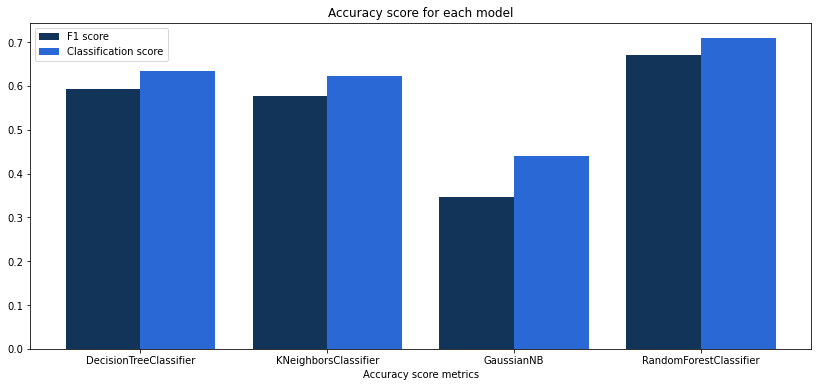

In [63]:
plot_model_results_metrics(classification_results, 'model',
                           'model_f1_score', 'F1 score',
                           'score', 'Classification score',
                           'Accuracy score for each model', 'Accuracy score metrics')

From the result metrics we can see that school responses had definitely correlated with the new covid cases in the European continent.</br></br>
It is expected not to have a perfect classification result as each country had their own adaptation system with the Covid-19 situation. Additionally, vaccinations got improved and introduced. Over time popularity also started to gain immunity as a community. Last but not least, it was quite common for each country to try and reopen schools as soon as possible in order to keep up with educational status.